In [1]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns
import os
import neptune
from neptune.types import File
import argparse 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from other_algorithms.pso import ParticleSwarmOptimizer
import time
from dotenv import load_dotenv
load_dotenv()

Using device: cpu


True

In [2]:
def initialize(config_path, mode="train", **kwargs):
    env = OptimizationEnv(config_path)
    agent_policy = MAPPO(config_path)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        agent_policy.load(model_path)
    return env, agent_policy

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent_policy, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        #print(observation[dim])
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent_policy.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions

In [3]:
config_path = 'config/config.json'
model_path = "models/timesteps-50000.pth"
mode = "test"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)
agent_policy.set_action_std(config["test_action_std"])

Loaded policy from:  models/timesteps-50000.pth


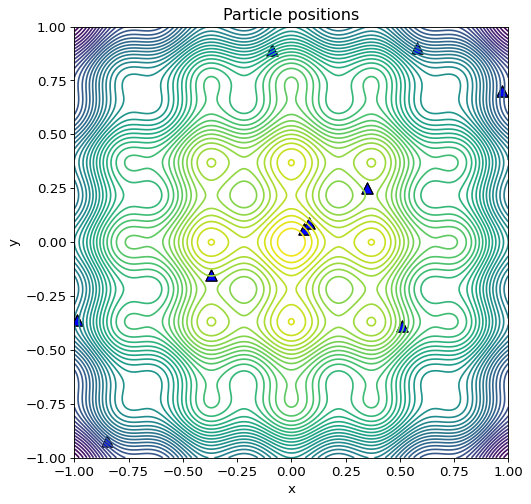

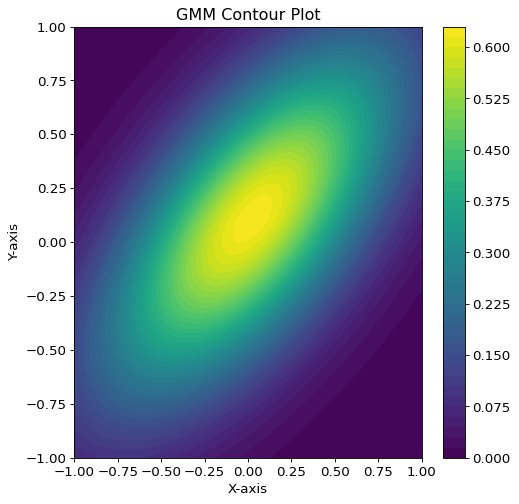

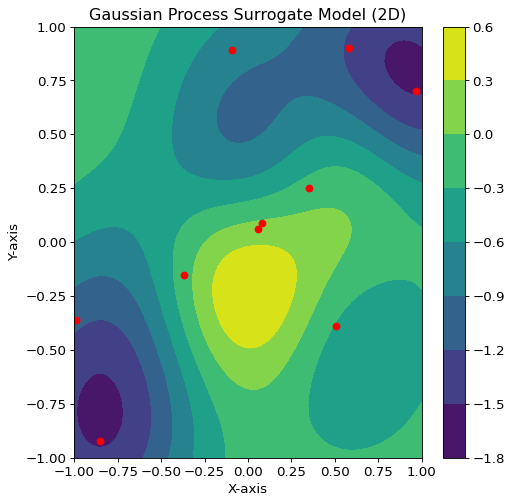

In [4]:
observation_info = env.reset()
env.render()
env.render(type="gmm")
env.render(type="surrogate")

In [11]:
actions = get_action(observation_info, agent_policy, env)

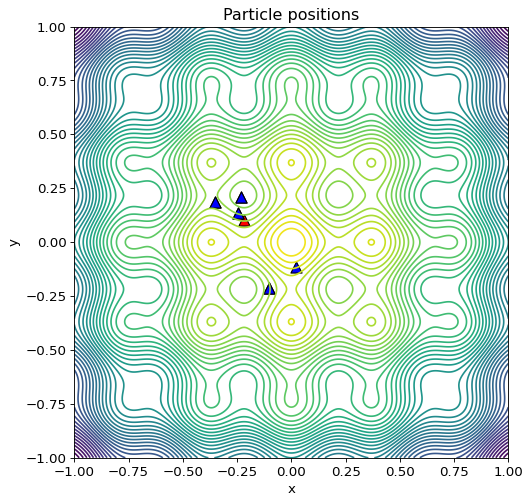

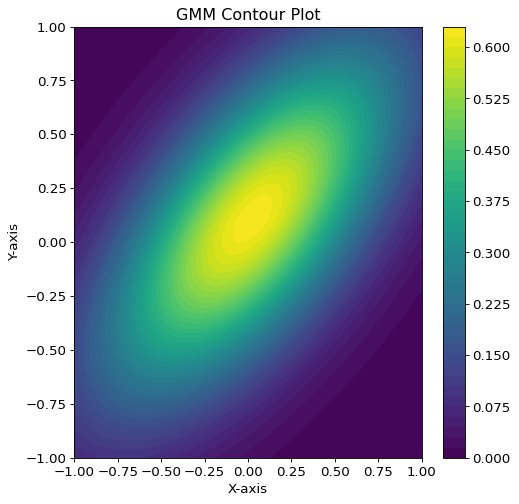

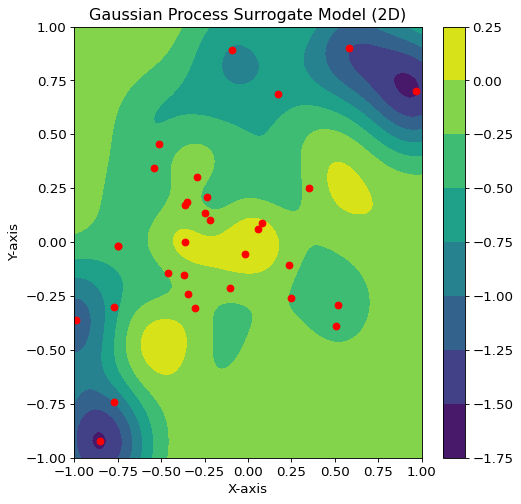

In [12]:
observation_info, reward, done, info = env.step(actions)
env.render()
env.render(type="gmm")
env.render(type="surrogate")

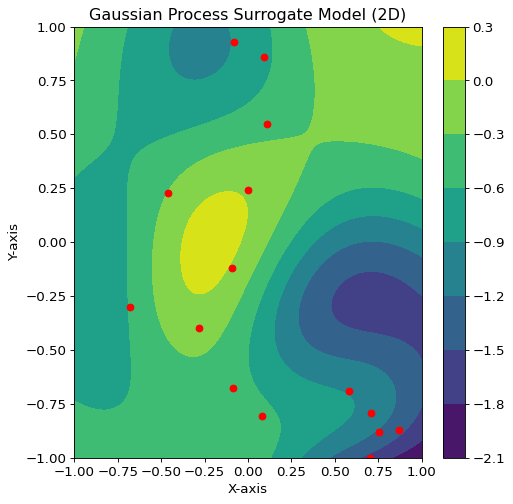

[-0.09       -0.12       -0.03775825]


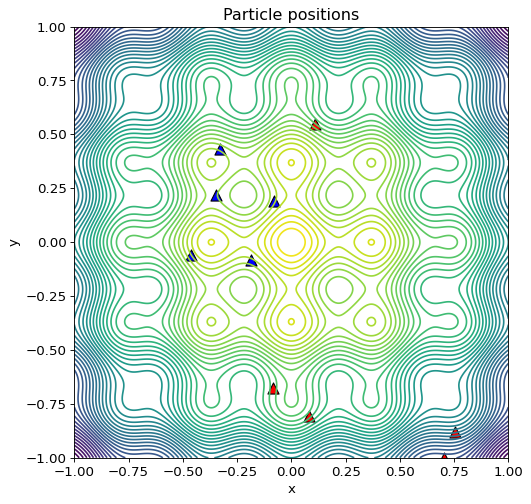

[-0.00982706  0.07555008] -0.03775825293347164
Found 2 surrogate agents better than gbest
[0.17936889 0.14423655] 0.0949958000970251
Found 2 surrogate agents better than gbest


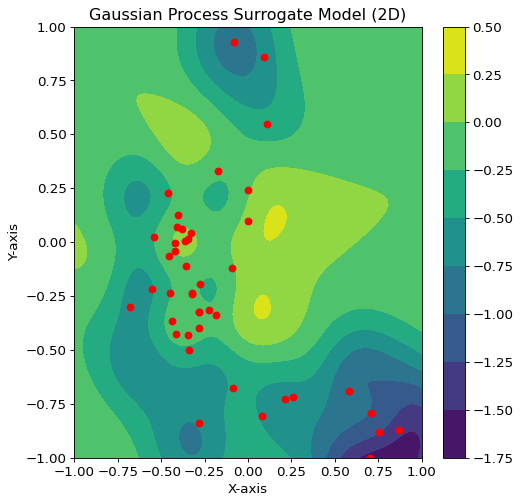

[-0.201       0.0142      0.17936889]


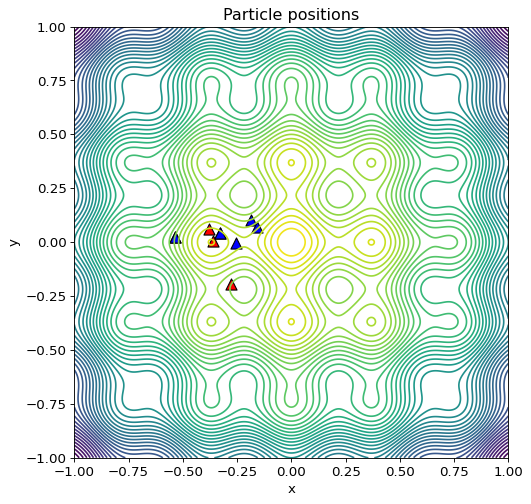

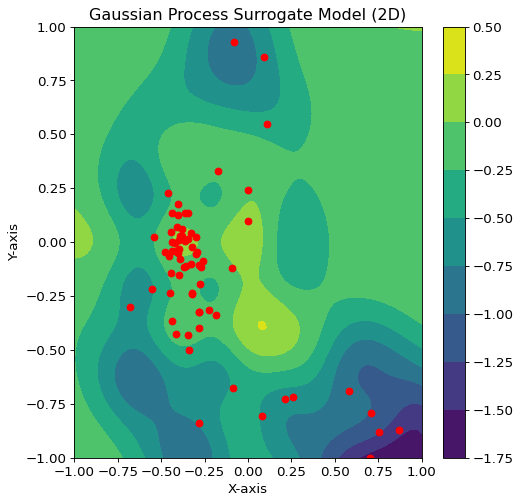

[-0.201       0.0142      0.17936889]


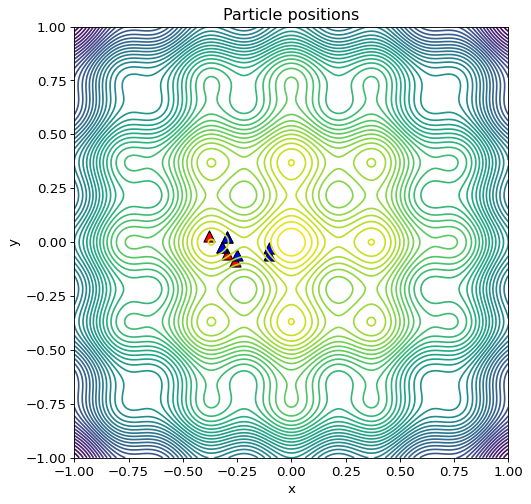

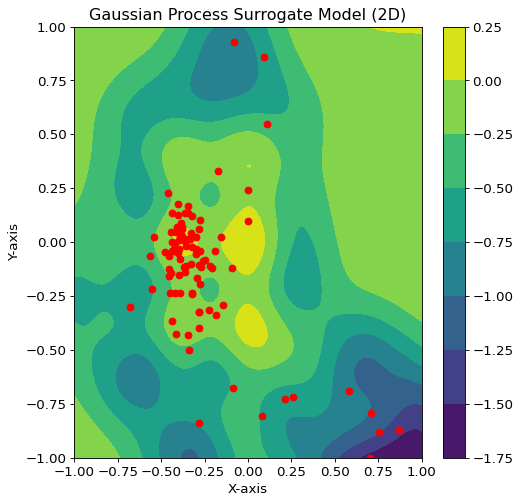

[-0.201       0.0142      0.17936889]


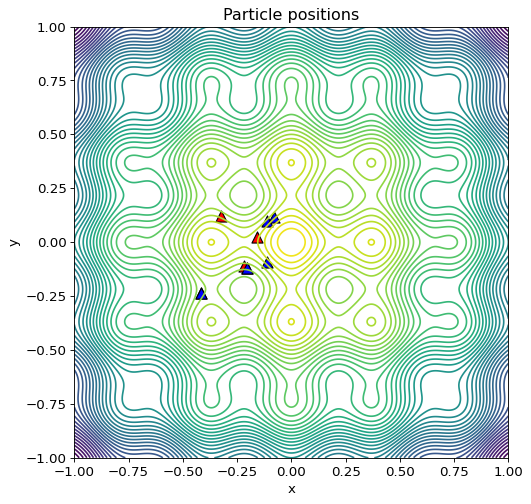

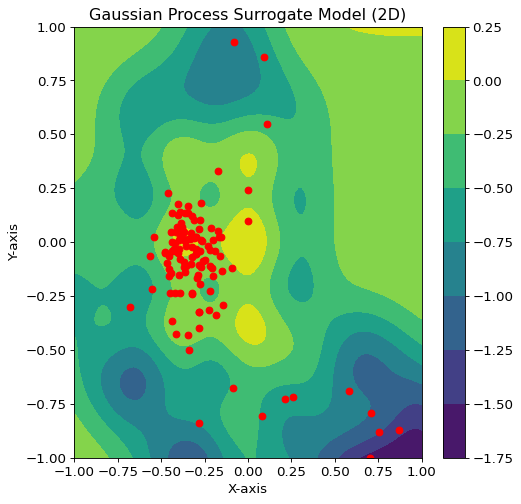

[-0.201       0.0142      0.17936889]


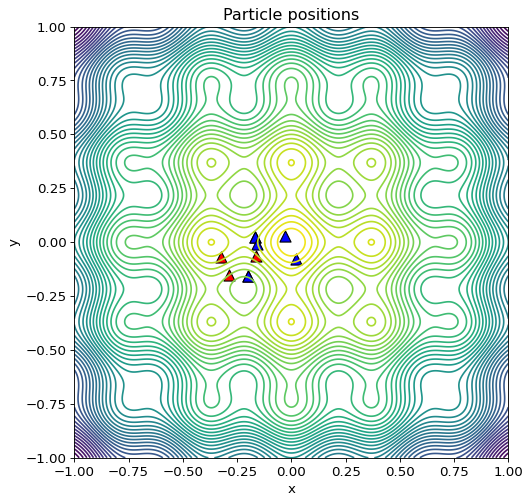

[0.19425143] 0.17936888500346324
Found 1 surrogate agents better than gbest


In [13]:
iters  = 25
obs = env.reset()
for i in range(iters):
    actions = get_action(obs, agent_policy, env)
    obs, reward, done, info = env.step(actions)
    if i % 5 == 0:
        env.render("surrogate")
        print(env.gbest)
        env.render()



In [21]:
gbest_hist_path = "testing_runs/2023-11-22_17-33-45/gbest_history_8.npy"
gbh = np.load(gbest_hist_path)
print(gbh)

[[-0.09       -0.13       -0.0547556 ]
 [-0.0222     -0.0974     -0.02504526]
 [-0.1774      0.3316      0.13058572]
 [-0.1774      0.3316      0.13058572]
 [-0.1774      0.3316      0.13058572]
 [-0.1216     -0.0336      0.17875796]
 [-0.1216     -0.0336      0.17875796]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272      0.20282145]
 [-0.0828      0.0272    

In [ ]:
env.gbest_history

In [ ]:
env.num_of_function_evals

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a, axis = 0), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h

def num_function_evaluation(fopt, n_agents, save_dir, opt_value, label="TEST OPT"):
    # convert fopt to numpy array if it is not already
        fopt = np.array(fopt)
        mf1 = np.mean(fopt, axis = 0)
        err = np.std(fopt, axis = 0)
        mf1, ml1, mh1 = mean_confidence_interval(fopt,0.95)

        fig = plt.figure(figsize=(6,4), dpi=200)
        plt.rcParams["figure.figsize"] = [6, 4]
        plt.rcParams["figure.autolayout"] = True
        plt.fill_between((np.arange(len(mf1))+1)*n_agents, ml1, mh1, alpha=0.1, edgecolor='#3F7F4C', facecolor='#7EFF99')
        plt.plot((np.arange(len(mf1))+1)*n_agents, mf1, linewidth=2.0, label = label, color='#3F7F4C')
        if opt_value is not None:
            plt.plot((np.arange(len(mf1))+1)*n_agents, np.ones(len(mf1))*opt_value, linewidth=1.0, label = 'True OPT', color='#CC4F1B')

        plt.xlabel('number of function evaluations', fontsize = 14)
        plt.ylabel('best fitness value', fontsize = 14)

        plt.legend(fontsize = 14, frameon=False)
        plt.xscale('log')
        plt.yticks(fontsize = 14)
        plt.savefig(save_dir)
        # close the figure
        plt.close(fig)

def plot_num_function_evaluation(fopt, n_agents, save_dir, opt_value, show_std=False, symbol_list=None, color_list=None, label_list=None, show=True, title=None):
        # The method implementation goes here
        fig = plt.figure(figsize=(6, 4), dpi=200)
        plt.rcParams["figure.figsize"] = [6, 4]
        plt.rcParams["figure.autolayout"] = True

        if symbol_list is None:
            symbol_list = ['-']
        if color_list is None:
            color_list = ['#3F7F4C']
        if label_list is None:
            label_list = ['DeepHive']

        print(f"Number of function evaluations: {len(fopt[0])}")
        print(f"Number of algorithms: {len(fopt)}")

        if len(fopt) == 1:
            print("Single algorithm")
            num_function_evaluation(fopt[0], n_agents, save_dir, opt_value, label=label_list[0])
        else:
            for i in range(len(fopt)):
                
                mf1, ml1, mh1 = mean_confidence_interval(fopt[i], 0.95)
                if show_std:
                    plt.errorbar((np.arange(len(mf1)) + 1) * n_agents, mf1, yerr=mh1 - ml1, linewidth=2.0,
                                label=label_list[i],
                                color=color_list[i])
                # plt.fill_between((np.arange(len(mf1)) + 1) * n_agents, ml1, mh1, alpha=0.1, edgecolor='#3F7F4C',
                #                  facecolor=color_list[i])
                plt.plot((np.arange(len(mf1)) + 1) * n_agents, mf1, symbol_list[i], linewidth=1, label=label_list[i],
                        color=color_list[i])

        if opt_value is not None:
            plt.plot((np.arange(len(mf1))+1)*n_agents, np.ones(len(mf1))*opt_value, linewidth=0.5, label = 'True OPT', color='#CC4F1B')

        plt.xlabel('number of function evaluations', fontsize=14)
        plt.ylabel('best fitness value', fontsize=14)
        plt.legend(fontsize=8, frameon=False, loc="lower right")
        plt.xscale('log')
        plt.yticks(fontsize=14)
        if title is not None:
            plt.title(title)
        if show:
            plt.show()
    
        plt.savefig(save_dir)
        #plt.close(fig)

In [ ]:
opt1_dir = "benchmarking_runs/2023-11-13_10-31-46"  # std = 0.05
opt2_dir = "benchmarking_runs/2023-11-13_10-34-03" # std = 0.02
opt3_dir = "benchmarking_runs/2023-11-13_10-35-39" # std = 0.035
opt4_dir = "benchmarking_runs/2023-11-13_10-37-39" # learn_std - 0.3 - 0.03
opt5_dir = "benchmarking_runs/2023-11-13_10-39-21" # learn_std - 0.5 - 0.005
opt6_dir = "benchmarking_runs/2023-11-13_10-40-59" # unfreeze learn_std - 0.4 - 0.02

opt_dirs = [opt1_dir, opt2_dir, opt3_dir, opt4_dir, opt5_dir, opt6_dir]
labels = ["std-0.05", "std-0.02", "std-0.035", "ls-0.3-0.03", "ls-0.5-0.005", "unfreeze-ls-0.4-0.02"]
colors = ["red", "green", "blue", "orange", "purple", "brown"]
symbols = ["-", "-", "-", "-", "-", "-"]

def prepare_opt_values(dir):
    # get all the .npy files in the directory
    opt_values = []
    files = os.listdir(dir)
    files = [file for file in files if file.endswith(".npy")]
    for file in files:
        opt_value = np.load(os.path.join(dir, file))
        # grab all the columns except the last one
        opt_value = opt_value[:, -1]
        #print(opt_value)
        opt_values.append(opt_value.tolist())
    return opt_values

ploting_values = []
for dir in opt_dirs:
    opt_values = prepare_opt_values(dir)
    ploting_values.append(opt_values)

plot_num_function_evaluation(ploting_values, 10, "benchmarking_runs/plot.png", 0.2, label_list=labels, show_std=False, color_list=colors, symbol_list=symbols, show=False, title="2D cosine mixture function benchmarking")

In [ ]:
opt1_dir = "benchmarking_runs/2023-11-13_10-57-38"  # std = 0.05
opt2_dir = "benchmarking_runs/2023-11-13_10-56-41" # std = 0.02
opt3_dir = "benchmarking_runs/2023-11-13_10-55-41" # std = 0.035
opt4_dir = "benchmarking_runs/2023-11-13_10-54-53" # learn_std - 0.3 - 0.03
opt5_dir = "benchmarking_runs/2023-11-13_10-53-53" # learn_std - 0.5 - 0.005
opt6_dir = "benchmarking_runs/2023-11-13_10-52-32" # unfreeze learn_std - 0.5 - 0.05

opt_dirs = [opt1_dir, opt2_dir, opt3_dir, opt4_dir, opt5_dir, opt6_dir]
labels = ["std-0.05", "std-0.02", "std-0.035", "ls-0.3-0.03", "ls-0.5-0.005", "unfreeze-ls-0.4-0.02"]
colors = ["red", "green", "blue", "orange", "purple", "brown"]
symbols = ["-", "-", "-", "-", "-", "-"]

def prepare_opt_values(dir):
    # get all the .npy files in the directory
    opt_values = []
    files = os.listdir(dir)
    files = [file for file in files if file.endswith(".npy")]
    for file in files:
        opt_value = np.load(os.path.join(dir, file))
        # grab all the columns except the last one
        opt_value = opt_value[:, -1]
        #print(opt_value)
        opt_values.append(opt_value.tolist())
    return opt_values

ploting_values = []
for dir in opt_dirs:
    opt_values = prepare_opt_values(dir)
    ploting_values.append(opt_values)

plot_num_function_evaluation(ploting_values, 10, "benchmarking_runs/plot1.png", 0.2, label_list=labels, show_std=False, color_list=colors, symbol_list=symbols, show=False, title="3D cosine mixture function benchmarking")

In [ ]:
plot_num_function_evaluation([opt_values_1, opt_values_2], 1, "test.png", 0.2, show_std=False, symbol_list=['-', '--'], color_list=['#3F7F4C', '#CC4F1B'], label_list=['DeepHive', 'PSO'])

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define a simple 2D grid space for demonstration
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)
X_flat = X.ravel()
Y_flat = Y.ravel()
grid_points = np.vstack((X_flat, Y_flat)).T

# Generate some random sample data for GMM fitting
n_samples = 300
sample_data = np.random.uniform(low=-3, high=3, size=(n_samples, 2))

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(sample_data)

# Predict the density for the grid points
gmm_density = gmm.score_samples(grid_points)

# Identify low-density regions
low_density_threshold = np.percentile(gmm_density, 10)  # for example, the bottom 10% of densities
low_density_points = grid_points[gmm_density < low_density_threshold]

# Gaussian Process - Assume we have some function observations to fit the GP
# For the purpose of this demonstration, we'll use the sample_data as observations
observations = np.random.rand(n_samples)  # Placeholder for actual function observations

# Define and fit Gaussian Process Regressor
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(sample_data, observations)

# Make predictions along our grid, include the mean and the variance (uncertainty)
gp_mean, gp_var = gp.predict(grid_points, return_std=True)
gp_var = gp_var ** 2  # Get variance from standard deviation

# Identify high-variance regions
high_variance_threshold = np.percentile(gp_var, 90)  # for example, the top 10% of variances
high_variance_points = grid_points[gp_var > high_variance_threshold]

# Return the low-density points from GMM and high-variance points from GP
low_density_points, high_variance_points


(array([[-3.        , -3.        ],
        [-2.93939394, -3.        ],
        [-2.87878788, -3.        ],
        ...,
        [ 2.87878788,  3.        ],
        [ 2.93939394,  3.        ],
        [ 3.        ,  3.        ]]),
 array([[-2.45454545, -3.        ],
        [-2.39393939, -3.        ],
        [-2.33333333, -3.        ],
        ...,
        [ 1.66666667,  3.        ],
        [ 1.72727273,  3.        ],
        [ 1.78787879,  3.        ]]))